# 311 Assignment - Identifying High Risk Requests

This project aims to help NYPD to prioritize incoming cases from 311 requests by using a predictive modelling approach. The model identifies high risk cases by using complaint type, geographic, timing, socio-economics, and Zillow neighbourhood index.

I used all requests received by 311 between Jan 1 to Dec 31, 2016 to develop insights and models. 

**The following sections are included in this Notebook:**
- Data ingestion, cleaning, and integration
- Visual exploration of key information (i.e. counts, geo map, etc.)
- Data processing for modelling (i.e. target definition, label encoding, rescaling, and standardization, etc.)
- Customed Time Series based Cross Validation
- Benchmark 5 popular classification models
- Test model performance on a reserved sample

**Out of Scope:**
- Feature Engineering
- Hyperparameter Tuning

***

## Summary & Discussion

**How can an Agency use this to improve servie delivery or performance?**
<br\>
An agency can incorporate the model insights into any existing prioritization and workforce allocation solutions. Doing this can help reduce operation cost by balancing the response time and risk of neglecting a true case.

**What are the limiation of your approach?**
<br\>
- Like any models that try to predict the future, there are bias, uncertainty, and error in the outcome. They are introduced by existing social context, data quality, and statistical assumptions.
- In addition, the definition of "High Risk Cases" can be further relaxed or restricted based on input from operators.

**What can we do to improve it?**
<br\>

1) Technical Improvement:
- Feature engineering (make new columns) with existing data or new third party sources
- Tune the hyperparamter of CART model; this model is better at picking out high risk cases and being conservative
- Try more advanced, but not black box, classification models (e.g. XGBoost and Random Forest)

2) Non-Technical Improvement:
- balance weighting of features based on inputs from group operators
- limit the focus on types of request based on existing demand

***

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import matplotlib.style as style
import warnings
import pprint as pprint

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
%pylab inline

/Users/Ian/anaconda/envs/python36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/Users/Ian/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Ingest Data

In [2]:
# 311 Request Dataset

path = "./data/311_Service_Requests_2016.csv"
df = pd.read_csv(path)

In [3]:
# House Price from Zillow

path = "./data/zillow.csv"
zillow = pd.read_csv(path)

In [4]:
df.columns = [col.replace(" ", "_") for col in df.columns]
df["Incident_Zip"] = df['Incident_Zip'].apply(str)

In [5]:
df.dtypes

Unique_Key                          int64
Created_Date                       object
Closed_Date                        object
Agency                             object
Agency_Name                        object
Complaint_Type                     object
Descriptor                         object
Location_Type                      object
Incident_Zip                       object
Incident_Address                   object
Street_Name                        object
Address_Type                       object
City                               object
Status                             object
Resolution_Description             object
Resolution_Action_Updated_Date     object
Community_Board                    object
Borough                            object
X_Coordinate_(State_Plane)        float64
Y_Coordinate_(State_Plane)        float64
Park_Borough                       object
Latitude                          float64
Longitude                         float64
dtype: object

In [6]:
print("# of Rows: " + str(df.shape[0]) + " | # of columns: " + str(df.shape[1]))

# of Rows: 2366185 | # of columns: 23


In [7]:
df.sample(10)

,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Complaint_Type,Descriptor,Location_Type,Incident_Zip,Incident_Address,...,Status,Resolution_Description,Resolution_Action_Updated_Date,Community_Board,Borough,X_Coordinate_(State_Plane),Y_Coordinate_(State_Plane),Park_Borough,Latitude,Longitude
245769,32615895,02/06/2016 11:01:00 AM,02/08/2016 12:00:00 PM,DSNY,A - Brooklyn,Dirty Conditions,E3 Dirty Sidewalk,Sidewalk,11238.0,468 GRAND AVENUE,...,Closed,The Department of Sanitation investigated this...,02/08/2016 12:00:00 PM,02 BROOKLYN,BROOKLYN,994914.0,187760.0,BROOKLYN,40.682028,-73.961551
1857198,34530229,10/13/2016 07:52:00 PM,10/18/2016 12:18:00 PM,DEP,Department of Environmental Protection,Water System,Hydrant Running Full (WA4),NaN,nan,NaN,...,Closed,The Department of Environmental Protection det...,10/18/2016 12:18:00 PM,Unspecified BRONX,BRONX,NaN,NaN,BRONX,NaN,NaN
391632,32782601,02/26/2016 04:16:00 PM,02/27/2016 12:00:00 PM,DSNY,Manhattan 05,Dirty Conditions,E2 Receptacle Violation,Sidewalk,10010,175 5 AVENUE,...,Closed,The Department of Sanitation investigated this...,02/27/2016 12:00:00 PM,05 MANHATTAN,MANHATTAN,987057.0,209291.0,MANHATTAN,40.741132,-73.989870
2156039,34887594,11/29/2016 01:05:57 PM,12/01/2016 02:28:06 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,11233.0,1566 EASTERN PARKWAY EXTENSION,...,Closed,The Department of Housing Preservation and Dev...,12/01/2016 02:28:06 AM,16 BROOKLYN,BROOKLYN,1007468.0,183741.0,BROOKLYN,40.670973,-73.916302
1670510,34311376,09/13/2016 11:08:48 AM,09/13/2016 11:09:00 AM,HRA,HRA Benefit Card Replacement,Benefit Card Replacement,Food Stamp,NYC Street Address,nan,NaN,...,Closed,The Human Resources Administration received yo...,NaN,0 Unspecified,Unspecified,NaN,NaN,Unspecified,NaN,NaN
186369,32539861,01/27/2016 05:03:48 PM,02/11/2016 09:27:19 AM,HPD,Department of Housing Preservation and Develop...,PLUMBING,TOILET,RESIDENTIAL BUILDING,10013,83 BAXTER STREET,...,Closed,The Department of Housing Preservation and Dev...,02/11/2016 09:27:19 AM,03 MANHATTAN,MANHATTAN,984325.0,200446.0,MANHATTAN,40.716855,-73.999729
810523,33275370,05/04/2016 10:44:28 AM,05/11/2016 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Failure To Maintain,NaN,11693,93-06 SHORE FRONT PARKWAY,...,Closed,The Department of Buildings investigated this ...,05/11/2016 12:00:00 AM,14 QUEENS,QUEENS,1035683.0,152099.0,QUEENS,40.584004,-73.814831
921041,33408334,05/21/2016 10:40:00 AM,05/23/2016 12:00:00 PM,DSNY,BCC - Brooklyn South,Dirty Conditions,E2 Receptacle Violation,Sidewalk,11218,110 EAST 2 STREET,...,Closed,The Department of Sanitation investigated this...,05/23/2016 12:00:00 PM,07 BROOKLYN,BROOKLYN,989949.0,175786.0,BROOKLYN,40.649167,-73.979462
1302321,33864169,07/18/2016 12:00:00 AM,07/18/2016 07:18:52 AM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10467.0,2715 BARNES AVENUE,...,Closed,The Police Department responded to the complai...,07/18/2016 07:18:52 AM,11 BRONX,BRONX,1022000.0,254803.0,BRONX,40.865969,-73.863517
1110974,33628251,06/19/2016 12:08:24 AM,06/19/2016 05:29:35 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Music,Street/Sidewalk,11213,145 SCHENECTADY AVENUE,...,Closed,The Police Department responded and upon arriv...,06/19/2016 05:29:35 AM,08 BROOKLYN,BROOKLYN,1002724.0,184844.0,BROOKLYN,40.674012,-73.933400


In [8]:
zillow = zillow[zillow.State == "NY"]
zillow['RegionName'] = zillow['RegionName'].apply(str)
zillow = zillow[["RegionName", "SizeRank", "Zhvi", "5Year"]]
zillow.sample(10)

,RegionName,SizeRank,Zhvi,5Year
8290,10536,8290,621100,0.013647
10449,14871,10449,122600,0.008534
8766,11565,8766,474800,0.049616
9947,11786,9947,390800,0.023235
11782,13060,11782,138200,0.010142
3927,13210,3927,132400,0.006311
10349,13053,10349,165400,0.027528
12691,12066,12691,131000,0.014171
5223,11795,5223,417400,0.042856
3613,11901,3613,344600,0.041872


In [9]:
zillow.dtypes

RegionName     object
SizeRank        int64
Zhvi            int64
5Year         float64
dtype: object

---

## 2. Preliminary Data Processing & Validation
- Remove rows with NAs in key columns
- Split date into date, hour, day of week features
- Merge 311 data with Zillow Home Price Index in Zip Code
- Group Request Type

### Remove NA in Key 311 Data Columns

In [10]:
keyCol = ["Created_Date", "Agency", "Complaint_Type", "Incident_Zip", "Status", "Borough", "Latitude", "Longitude"]

ADS = df

for col in keyCol:
    ADS = ADS[ADS[col].notnull()]

print("# of Rows Removed: " + str(df.shape[0] - ADS.shape[0]) + " | # of Rows: " + str(ADS.shape[0]))

# of Rows Removed: 214846 | # of Rows: 2151339


In [11]:
# Validate number of NA in key columns
na_count = {}

for col in keyCol:
    na_count[col] = ADS[col].isnull().sum()
    
print(na_count)

{'Created_Date': 0, 'Agency': 0, 'Complaint_Type': 0, 'Incident_Zip': 0, 'Status': 0, 'Borough': 0, 'Latitude': 0, 'Longitude': 0}


### Split Datetime into Date, Hour, Day of Week
**NOTE: Using pd.to_datetime takes too long on my machine due to dateset size; use user define function instead**

In [12]:
# Extract month, day of the week, hour
def get_date(x):
    '''
    Extract date from datetime string.
    '''
    
    try:
        date = x.split(" ")[0]
    except: 
        date = "00/00/0000"
    return date

def get_time(x):
    '''
    Extract time from datetime string.
    '''
    
    try:
        time = x.split(" ")[1] + " " + x.split(" ")[2]
    except: 
        time = "99:99:99 AM"
    return time

ADS["Open_Date"] = ADS["Created_Date"].apply(lambda x: get_date(x)) 
ADS["Open_Time"] = ADS["Created_Date"].apply(lambda x: get_time(x))
ADS["Resolved_Date"] = ADS["Closed_Date"].apply(lambda x: get_date(x))
ADS["Resolved_Time"] = ADS["Closed_Date"].apply(lambda x: get_time(x))

In [13]:
def get_month(x):
    
    '''Extract month from date string'''
    try:
        month = int(x.split("/")[0].lstrip("0"))
    except: 
        month = 99
    
    return month

def get_day(x):
    
    '''Extract day from date string'''
    try:
        day = int(x.split("/")[1].lstrip("0"))
    except:
        day = 99
    
    return day

def get_year(x):
    
    '''Extract day from date string'''
    try:
        year = int(x.split("/")[2].lstrip("0"))
    except:
        year = 99
    
    return year

def get_hour(x):
    
    '''Extract hour from time string'''
    
    try:
        hour = int(x.split(":")[0].lstrip("0"))
        if x.split(" ")[1] == "PM" and hour != 12:
            hour = hour + 12
    except:
        hour = 99
    
    return hour

ADS["Open_Month"] = ADS["Open_Date"].apply(lambda x: get_month(x))
ADS["Open_Day"] = ADS["Open_Date"].apply(lambda x: get_day(x))
ADS["Open_Year"] = ADS["Open_Date"].apply(lambda x: get_year(x))
ADS["Open_Hour"] = ADS["Open_Time"].apply(lambda x: get_hour(x)) 

ADS["Resolved_Month"] = ADS["Resolved_Date"].apply(lambda x: get_month(x))
ADS["Resolved_Day"] = ADS["Resolved_Date"].apply(lambda x: get_day(x))
ADS["Resolved_Year"] = ADS["Resolved_Date"].apply(lambda x: get_year(x))
ADS["Resolved_Hour"] = ADS["Resolved_Time"].apply(lambda x: get_hour(x)) 

#### Validate Datetime Split by Randomly Selecting 10 rows

In [14]:
ADS[["Created_Date","Open_Date", "Open_Time", \
     "Open_Month", "Open_Day", "Open_Year", "Open_Hour"]].sample(10)

,Created_Date,Open_Date,Open_Time,Open_Month,Open_Day,Open_Year,Open_Hour
923789,05/21/2016 10:01:54 PM,05/21/2016,10:01:54 PM,5,21,2016,22
2110652,11/21/2016 05:00:08 PM,11/21/2016,05:00:08 PM,11,21,2016,17
1580896,08/30/2016 12:00:00 AM,08/30/2016,12:00:00 AM,8,30,2016,12
1266230,07/12/2016 01:09:40 PM,07/12/2016,01:09:40 PM,7,12,2016,13
1812414,10/06/2016 11:39:51 AM,10/06/2016,11:39:51 AM,10,6,2016,11
2348471,12/28/2016 09:41:18 AM,12/28/2016,09:41:18 AM,12,28,2016,9
516904,03/17/2016 02:51:35 PM,03/17/2016,02:51:35 PM,3,17,2016,14
827590,05/06/2016 07:50:29 PM,05/06/2016,07:50:29 PM,5,6,2016,19
1349818,07/25/2016 08:40:53 AM,07/25/2016,08:40:53 AM,7,25,2016,8
1869449,10/15/2016 09:54:41 PM,10/15/2016,09:54:41 PM,10,15,2016,21


In [15]:
ADS[["Closed_Date","Resolved_Date", "Resolved_Time", \
     "Resolved_Month", "Resolved_Day", "Resolved_Year", "Resolved_Hour"]].sample(10)

,Closed_Date,Resolved_Date,Resolved_Time,Resolved_Month,Resolved_Day,Resolved_Year,Resolved_Hour
2029526,11/10/2016 03:04:13 PM,11/10/2016,03:04:13 PM,11,10,2016,15
1861238,11/07/2016 10:15:27 AM,11/07/2016,10:15:27 AM,11,7,2016,10
1881038,10/17/2016 11:20:07 PM,10/17/2016,11:20:07 PM,10,17,2016,23
2309991,12/25/2016 12:00:00 AM,12/25/2016,12:00:00 AM,12,25,2016,12
311545,02/18/2016 07:54:06 AM,02/18/2016,07:54:06 AM,2,18,2016,7
1961632,10/29/2016 09:36:20 AM,10/29/2016,09:36:20 AM,10,29,2016,9
1846692,10/12/2016 03:46:44 PM,10/12/2016,03:46:44 PM,10,12,2016,15
611091,04/01/2016 09:23:12 PM,04/01/2016,09:23:12 PM,4,1,2016,21
963852,05/28/2016 12:00:00 PM,05/28/2016,12:00:00 PM,5,28,2016,12
1848272,10/12/2016 07:15:35 PM,10/12/2016,07:15:35 PM,10,12,2016,19


### Join 311 Request data with Zillow data

In [16]:
ADS = pd.merge(ADS, zillow, how = "left", left_on = ["Incident_Zip"], right_on = ["RegionName"]).fillna(0)

In [17]:
ADS[["Incident_Zip", "Complaint_Type", "Zhvi"]].sample(10)

,Incident_Zip,Complaint_Type,Zhvi
821810,10003,Collection Truck Noise,0.0
354210,10467,HEAT/HOT WATER,0.0
1733507,11104,HEAT/HOT WATER,0.0
1038726,10470,Blocked Driveway,437800.0
1388617,11372,Noise - Residential,0.0
356594,10467,UNSANITARY CONDITION,0.0
944421,11420.0,Street Condition,0.0
812101,11233,ELECTRIC,733000.0
1025873,11206,Blocked Driveway,656800.0
2141914,11436.0,Derelict Vehicles,0.0


---

## 3. Preliminary Data Exploration

**Geo Anaylysis**
- Spatial map

**Count Breakdown**
- Complaint Type Breakdown
- Borough
- Zip Code
- Request Time
- Status
- Agency
- Status


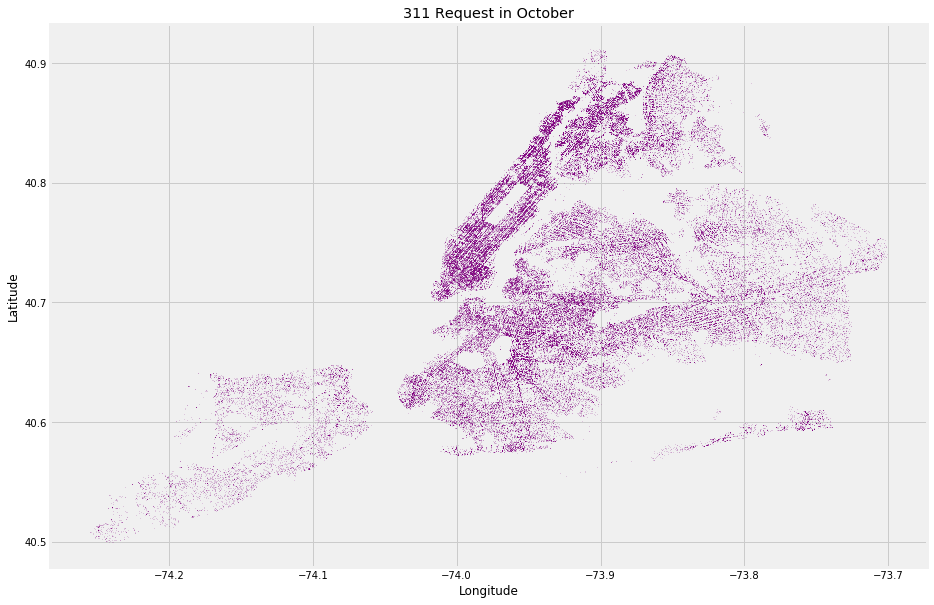

In [18]:
figure(figsize=(14,8));

ADS[(ADS.Open_Month == 10)].plot(kind='scatter', 
                                x='Longitude', y='Latitude',
                                s=.04, alpha=.5,
                                color = "purple",
                                figsize=(14,10),
                                title = "311 Request in October");

In [19]:
# Count Breakdown of Key Columns
keyCol = ["Complaint_Type", "Borough", "Incident_Zip", "Open_Month", "Open_Hour", "Status", 
          "Agency", "Resolution_Description"]

countDict = {}

for col in keyCol:
    tmp_df = ADS[col].value_counts().reset_index()
    tmp_df.columns = [col, "Count"]
    tmp_df["Perc_Total_%"] = tmp_df.Count *100 / len(ADS)
    countDict[col] = tmp_df

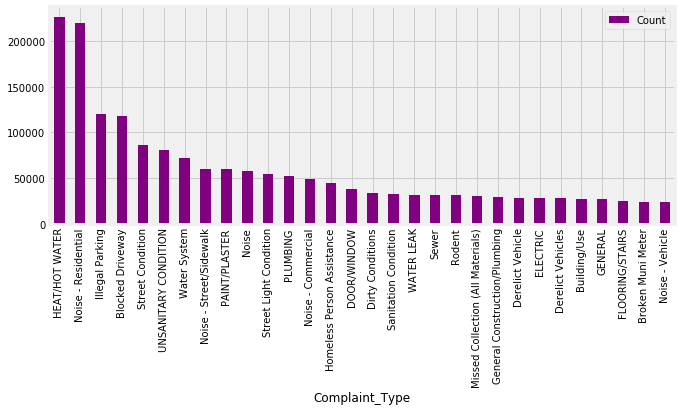

In [20]:
countDict["Complaint_Type"].head(30).plot(kind = "bar", 
                                          x = "Complaint_Type", 
                                          y = "Count",
                                          color = "purple",
                                          figsize=(10,4));

In [21]:
countDict["Complaint_Type"].head(10)

,Complaint_Type,Count,Perc_Total_%
0,HEAT/HOT WATER,227009,10.551986
1,Noise - Residential,220295,10.239902
2,Illegal Parking,119954,5.575783
3,Blocked Driveway,118176,5.493137
4,Street Condition,86701,4.030095
5,UNSANITARY CONDITION,80335,3.734186
6,Water System,71499,3.323465
7,Noise - Street/Sidewalk,60279,2.801929
8,PAINT/PLASTER,60250,2.800581
9,Noise,57542,2.674706


In [22]:
print("# of Unique Complaint Type: " + str(len(countDict["Complaint_Type"])))

# of Unique Complaint Type: 192


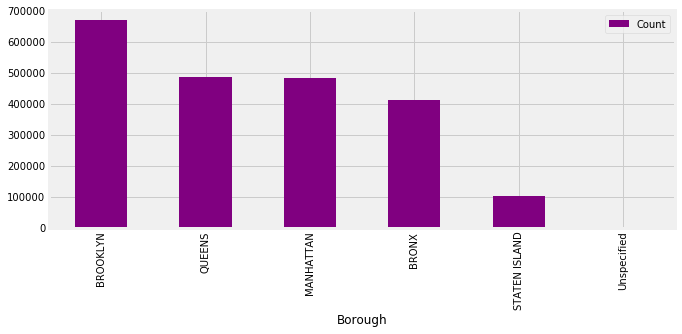

In [23]:
countDict["Borough"].plot(kind = "bar", 
                          x = "Borough", 
                          y = "Count",
                          color = "purple",
                          figsize=(10,4));

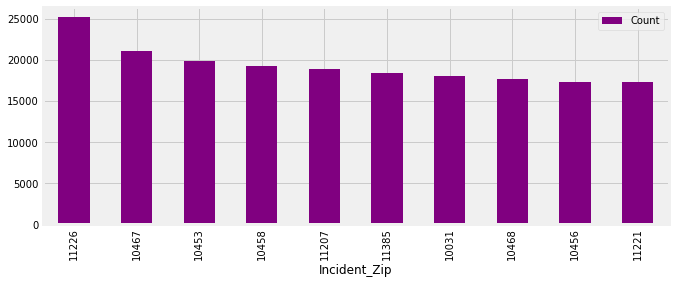

In [24]:
countDict["Incident_Zip"].head(10).plot(kind = "bar", 
                                        x = "Incident_Zip", 
                                        y = "Count",
                                        color = "purple",
                                        figsize=(10,4));

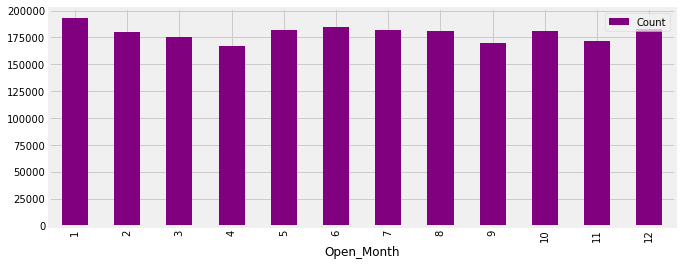

In [25]:
countDict["Open_Month"].sort_values("Open_Month").plot(kind="bar", 
                                                       x = "Open_Month", 
                                                       y = "Count",
                                                       color = "purple",
                                                       figsize = (10,4));

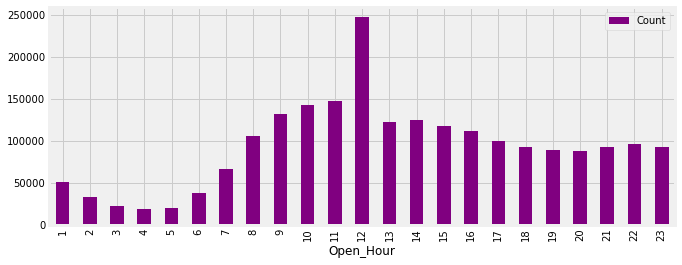

In [26]:
countDict["Open_Hour"].sort_values("Open_Hour").plot(kind="bar", 
                                                     x = "Open_Hour", 
                                                     y = "Count", 
                                                     color = "purple",
                                                     figsize = (10,4));

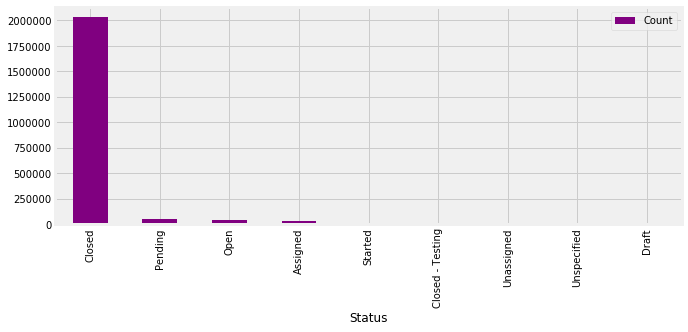

In [27]:
countDict["Status"].plot(kind="bar", 
                         x = "Status", 
                         y = "Count", 
                         color = "purple",
                         figsize=(10,4));

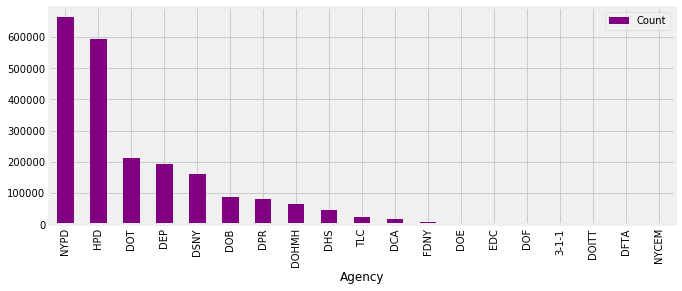

In [28]:
countDict["Agency"].plot(kind="bar", 
                         x = "Agency", 
                         y = "Count", 
                         color = "purple",
                         figsize=(10,4));

In [29]:
countDict["Agency"]

,Agency,Count,Perc_Total_%
0,NYPD,663586,30.845255
1,HPD,592446,27.538477
2,DOT,213342,9.916708
3,DEP,192818,8.962697
4,DSNY,160922,7.480086
5,DOB,86263,4.009735
6,DPR,80514,3.742506
7,DOHMH,66178,3.076131
8,DHS,44626,2.074336
9,TLC,23805,1.106520


In [30]:
# Unique Resolution Description Count by Agency

ADS.groupby("Agency")['Resolution_Description'].nunique()

Agency
3-1-1      4
DCA       28
DEP      165
DFTA       7
DHS       12
DOB       45
DOE       12
DOF        8
DOHMH     75
DOITT     19
DOT       99
DPR       97
DSNY      64
EDC        4
FDNY       9
HPD       28
NYCEM      1
NYPD      16
TLC        4
Name: Resolution_Description, dtype: int64

In [31]:
# List all unique NYPD case resolution

pprint.pprint(ADS[ADS.Agency == "NYPD"].Resolution_Description.unique())

array([ 'The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.',
       'The Police Department responded to the complaint and determined that police action was not necessary.',
       'The Police Department responded to the complaint and took action to fix the condition.',
       "This complaint does not fall under the Police Department's jurisdiction.",
       'The Police Department responded and upon arrival those responsible for the condition were gone.',
       'The Police Department responded to the complaint but officers were unable to gain entry into the premises.',
       'The Police Department issued a summons in response to the complaint.',
       'The Police Department reviewed your complaint and provided additional information below.',
       'Your request can not be processed at this time because of insufficient contact information. Please create a new Service Request on NYC.gov and provide m

***

## 4. Data Processing for Modelling

- Data Filtering: NYPD cases, Status is closed as of 2017-10-06 *(dataset download date)*, and exclude December
- Target Assignment: Issue was found based on Investigation using Resolution Description
- Feature Selection: Only keep the columns that may be relevant and do not leak future information
- Lable Categorical data with numerics; Rescale and standardize numerical data

### Data Filtering (only NYPD Cases)

In [66]:
# Reserve the last month for Out of Sample testing

NYPD = ADS[(ADS["Agency"] == "NYPD") & (ADS["Status"] == "Closed")]
NYPD.shape

(663444, 39)

### Target Assignment
- 1: Upon arrival, NYPD found evidence and actioned or referred the request to another department
- 0: Otherwise

In [67]:
def assign_class(x):
    
    evidence = ['The Police Department responded to the complaint and took action to fix the condition.',
               'The Police Department issued a summons in response to the complaint.',
               'The Police Department reviewed your complaint and provided additional information below.',
               'The Police Department responded to the complaint and a report was prepared.',
               'The Police Department made an arrest in response to the complaint.',
               'The Department of Parks and Recreation performed the work necessary to correct the condition.',
               ]
    
    if x in evidence:
        target = "1"
    else:
        target = "0"
    
    return target

NYPD['Target'] = NYPD["Resolution_Description"].apply(lambda x: assign_class(x))

In [68]:
NYPD['Target'].value_counts()

0    433181
1    230263
Name: Target, dtype: int64

In [69]:
pd.set_option('max_colwidth', 300)
NYPD[['Target','Resolution_Description']].sample(10)

,Target,Resolution_Description
660890,0,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.
1807214,1,The Police Department responded to the complaint and took action to fix the condition.
1678695,1,The Police Department responded to the complaint and took action to fix the condition.
1144606,0,The Police Department responded and upon arrival those responsible for the condition were gone.
439866,1,The Police Department responded to the complaint and took action to fix the condition.
907112,0,The Police Department responded and upon arrival those responsible for the condition were gone.
1423057,1,The Police Department reviewed your complaint and provided additional information below.
253370,1,The Police Department issued a summons in response to the complaint.
1301025,0,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.
1286933,0,The Police Department responded and upon arrival those responsible for the condition were gone.


In [70]:
keepCol = ['Target', 'Complaint_Type','Open_Month', 'Open_Day', 'Open_Hour', 
           'Borough', 'Incident_Zip', 'SizeRank', 'Zhvi', '5Year']
NYPD = NYPD[keepCol]

In [71]:
NYPD.sample(10)

,Target,Complaint_Type,Open_Month,Open_Day,Open_Hour,Borough,Incident_Zip,SizeRank,Zhvi,5Year
1870070,0,Noise - Residential,11,14,9,QUEENS,11362,6656.0,806800.0,0.057794
1411386,1,Noise - Commercial,8,25,20,MANHATTAN,10014,435.0,1691700.0,0.141568
1047985,0,Noise - Residential,6,25,17,BROOKLYN,11206.0,0.0,0.0,0.000000
878633,1,Noise - Residential,5,28,20,BRONX,10473.0,0.0,0.0,0.000000
1682230,0,Noise - Street/Sidewalk,10,13,14,BROOKLYN,11226.0,0.0,0.0,0.000000
827234,1,Illegal Parking,5,20,5,BROOKLYN,11208,269.0,453000.0,0.093679
974323,0,Noise - Commercial,6,13,21,BROOKLYN,11213,349.0,955900.0,0.125576
902953,0,Posting Advertisement,6,1,22,STATEN ISLAND,10312,863.0,527800.0,0.055753
752894,1,Illegal Parking,5,7,12,BROOKLYN,11228,3431.0,897900.0,0.081311
271542,1,Blocked Driveway,2,14,8,BROOKLYN,11226.0,0.0,0.0,0.000000


### Label Encode and Standardize Data

In [72]:
# Convert Categorical Data to Numerical Lables and Rescale / Standardize Numerical Data

def preprocess(df):
    
    col2Encode = list(df.select_dtypes(include = ["category", "object"]))
    col2Standardize = list(df.select_dtypes(include = ["float64"]))
    le = LabelEncoder()
    
    for col in col2Encode:
        if col != "Target":
            try:
                df[col] = le.fit_transform(df[col])
            except Exception as e:
                print("Failed to label %s: %s" &(col, e))
    
    # Rescale numbers between 0 and 1
    try:
        mms = MinMaxScaler(feature_range=(0,1))
        df[col2Standardize] = mms.fit_transform(df[col2Standardize])
    
    except Exception as e:
        print("Failed to rescale: %s" &(e))
    
    # Standardize numbers with 0 mean and std of 1
    try:
        scaler = StandardScaler().fit(df[col2Standardize])
        df[col2Standardize] = scaler.transform(df[col2Standardize])
    except Exception as e:
        print("Failed to standardize: %s" &(e)) 
                
    return df

NYPD = preprocess(NYPD)
NYPD.sample(n=10)

,Target,Complaint_Type,Open_Month,Open_Day,Open_Hour,Borough,Incident_Zip,SizeRank,Zhvi,5Year
665840,0,16,4,21,23,0,173,-0.415732,-0.694162,-0.763489
1755295,0,11,10,25,19,3,398,0.208431,0.914966,0.939102
1657526,1,15,10,9,12,2,60,-0.415732,-0.694162,-0.763489
133043,1,12,1,22,2,2,18,-0.415732,-0.694162,-0.763489
1457286,0,16,9,3,2,2,63,-0.415732,-0.694162,-0.763489
1242407,0,15,7,28,12,0,192,-0.415732,-0.694162,-0.763489
1456341,1,12,9,2,23,1,300,-0.302845,1.555040,2.190368
1609536,0,12,9,29,20,0,197,3.620719,0.309508,0.132968
1945069,0,12,11,26,21,2,44,-0.415732,-0.694162,-0.763489
1577395,1,15,9,23,23,1,230,-0.392438,1.965174,1.804902


## 5. Benchmark Models with Time Series Based Cross Validation
- Create Training, Testing, Reserved datasets based on month
- Select various classification models (only simple ones)
- Calculate performance benchmark (i.e. accuracy, % of false negative) based on repeated random sampling

In [73]:
# Create three dataset; i.e Training: Jan - Oct 2016, Testing: Nov 2016, Reserved: Dec 2016

def splitData(data):
    
    '''
    This function split data into three sets based on request time: training, testing, and reserved test set.
    
    Training data timeframe: first month to third last month (i.e. if full data has Jan-Dec, it will be Jan-Oct)
    Testing data timeframe: second last month (i.e. if full data has Jan-Dec, it will be Nov)
    Reserved data timeframe: last month (i.e. if full data has Jan-Dec, it will be Dec)
    
    Arg:
    data -- the dataset that one wants to split
    
    Return: training, test, and reserved datasets
    
    '''
        
    dTrain = data[(data.Open_Month >= min(NYPD.Open_Month)) & (data.Open_Month < max(data.Open_Month) - 1)]
    dTest = data[data.Open_Month == max(data.Open_Month) - 1]
    rTest = data[data.Open_Month == max(data.Open_Month)]
    
    return dTrain, dTest, rTest

dTrain, dTest, rTest = splitData(NYPD)

In [74]:
dTrain.sample(10)

,Target,Complaint_Type,Open_Month,Open_Day,Open_Hour,Borough,Incident_Zip,SizeRank,Zhvi,5Year
74283,0,2,1,12,20,1,284,-0.393632,1.230876,1.166609
797192,0,15,5,14,23,3,349,-0.415732,-0.694162,-0.763489
1383347,0,16,8,20,23,0,189,-0.415732,-0.694162,-0.763489
715757,0,13,5,1,2,2,25,0.745390,6.419332,0.651855
975267,0,2,6,14,12,0,169,-0.400800,0.093093,0.199199
683838,0,11,4,25,12,0,174,-0.415732,-0.694162,-0.763489
717076,0,2,5,1,12,1,262,-0.415732,-0.694162,-0.763489
330322,1,15,2,22,21,2,67,-0.415732,-0.694162,-0.763489
1232042,0,4,7,26,13,4,154,-0.415732,-0.694162,-0.763489
1087342,0,11,7,1,23,1,276,-0.209071,1.510336,1.725585


In [75]:
# Should have Every Month but November
dTrain['Open_Month'].describe()

count    562297.000000
mean          5.809611
std           2.759490
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: Open_Month, dtype: float64

In [76]:
# Should only have November
dTest['Open_Month'].describe()

count    51191.0
mean        11.0
std          0.0
min         11.0
25%         11.0
50%         11.0
75%         11.0
max         11.0
Name: Open_Month, dtype: float64

In [77]:
def repeated_Randome_Test(repetition, sample_size, model, dTrain, dTest):
    
    '''
    This is an tailored and automated Cross Validation function based on Time Series Tests. 
    Training and Testing data are selected randomly in repetition.
    
    It returns lists of accuracy and false negative rates of each repetition.
    
    Arg:
    Repetition -- number of repetition of training and testing
    sample_size -- the portion of training and testing data in the total (i.e 30%)
    model -- the model object for training and testing (i.e Logistic Regression)
    dTrain -- the training dataset
    dTest -- the testing dataset
    
    return:
    accuracy -- a list of individual accuracy score from each repetition (% of test data)
    false_neg -- a list of False Negative rate from each repetition (% of test data)
    prediction -- a list of prediction from each repetition
    
    '''
    
    accuracy = []
    fn = []
    fp = []
    tn = []
    tp = []
    prediction = []
    
    for i in range(repetition):
        sampleTrain = dTrain.sample(int(sample_size*len(dTrain)))
        sampleTest = dTest.sample(int(sample_size*len(dTest)))
        
        XTrain = sampleTrain.values[:, 1:len(sampleTrain.columns)]
        YTrain = sampleTrain.values[:, 0]

        XTest = sampleTest.values[:, 1:len(sampleTest.columns)]
        YTest = sampleTest.values[:, 0]
        
        # measure accuracy score
        model.fit(XTrain, YTrain)
        accuracy.append(model.score(XTest, YTest))
        
        # measure False Negative as the % of Sampled Test Data Size
        predicted = model.predict(XTest)
        cm = confusion_matrix(YTest, predicted)
        fp.append(cm[0][1]/int(sample_size*len(dTest)))
        fn.append(cm[1][0]/int(sample_size*len(dTest)))
        tp.append(cm[1][1]/int(sample_size*len(dTest)))
        tn.append(cm[0][0]/int(sample_size*len(dTest)))
        # collect prediced outcome
        prediction.append(predicted)
        
    return accuracy, fp, fn, tp, tn, prediction

In [78]:
# Pick all simple classificaiton models for benchmarking

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [106]:
accuracyList = []
truePosList = []
falseNegList = []
names = []

print("Name | Accuracy(%) | FP(%) | FN(%) | TP(%) | TN(%)")
for name, model in models:
    
    accuracy, fp, fn, tp, tn, prediction = repeated_Randome_Test(10, 0.33, model, dTrain, dTest)
    accuracyList.append(accuracy)
    truePosList.append(tp)
    falseNegList.append(fn)
    names.append(name)
    
    print("%s | %.3f | %.3f | %.3f | %.3f | %.3f " \
          %(name, np.mean(accuracy)*100, np.mean(fp)*100, np.mean(fn)*100,\
           np.mean(tp)*100, np.mean(tn)*100))

Name | Accuracy(%) | FP(%) | FN(%) | TP(%) | TN(%)
LR | 67.278 | 0.000 | 32.722 | 0.000 | 67.278 
LDA | 67.163 | 0.000 | 32.837 | 0.000 | 67.163 
KNN | 60.890 | 15.541 | 23.569 | 9.232 | 51.659 
CART | 57.344 | 22.019 | 20.638 | 12.240 | 45.104 
NB | 66.472 | 1.706 | 31.822 | 0.957 | 65.515 


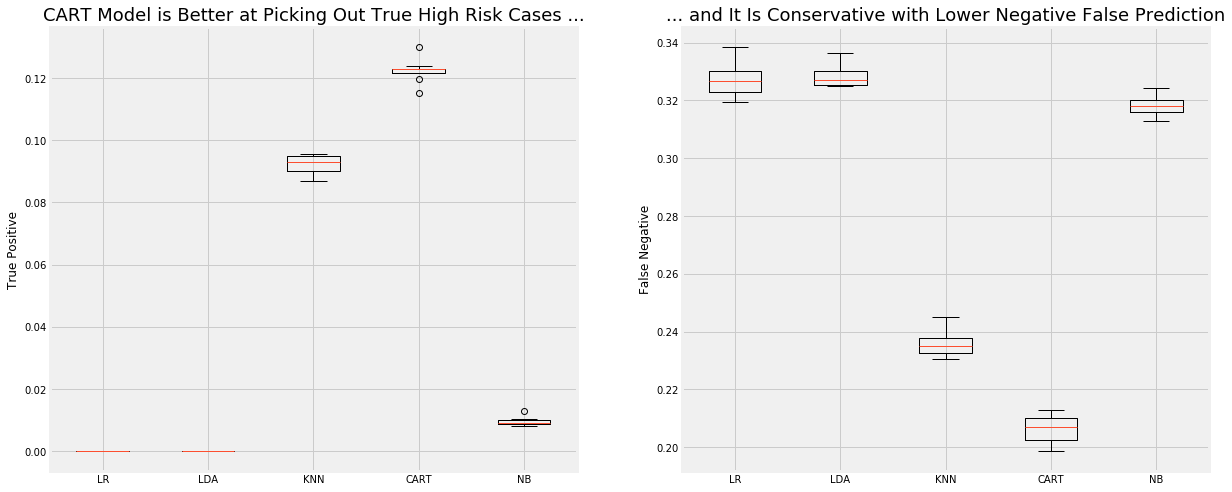

In [121]:
fig = matplotlib.pyplot.gcf()

fig1 = plt.subplot2grid((2,2), (1,0), colspan = 1)
fig1.boxplot(truePosList)
fig1.set_xticklabels(names)
fig1.set_ylabel("True Positive")
fig1.set_title("CART Model is Better at Picking Out True High Risk Cases ...", fontsize = 18)

fig2 = plt.subplot2grid((2,2), (1,1), colspan = 1)
fig2.boxplot(falseNegList)
fig2.set_xticklabels(names)
fig2.set_ylabel("False Negative")
fig2.set_title("... and It Is Conservative with Lower Negative False Prediction", fontsize = 18)

fig.set_size_inches(18.5, 18)

## Observation: 
Althgouth Logistic Regression and Linear Discrimatant Analysis have the highest accuracy, they are simply predicting all requests to be low risk. This is based on analyzing the False Negative and True Negative rates.

We should further improve **CART model** in the future because:
- It has better ability to predict actual high risk cases (high True Positive rate)
- It is more conservative, so it helps to mitigate risk of missing a potential case (low False Negative rate)

***

## 6. Test on Reserved Dataset

In [81]:
#Create a Training dataset with request from Jan - Nov
rTrain = dTrain.append(dTest)
rTrain["Open_Month"].describe()

count    613488.000000
mean          6.242711
std           3.006621
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          11.000000
Name: Open_Month, dtype: float64

In [82]:
rTest = preprocess(rTest)
rTest.sample(5)

,Target,Complaint_Type,Open_Month,Open_Day,Open_Hour,Borough,Incident_Zip,SizeRank,Zhvi,5Year
1980833,1,2,12,2,21,1,277,-0.180451,-0.281049,-0.305473
1981342,0,12,12,2,22,1,301,-0.180451,-0.281049,-0.305473
2070354,1,11,12,16,13,0,187,-0.180451,-0.281049,-0.305473
2080652,1,15,12,18,12,2,43,-0.180451,-0.281049,-0.305473
2087470,1,15,12,19,10,1,239,-0.180451,-0.281049,-0.305473


In [86]:
print("===== Apply Model to Reserved Sample from Dec 2016 =====")
print("Name | Accuracy(%) | FP(%) | FN(%) | TP(%) | TN(%)")

for name, model in models:
    
    accuracy, fp, fn, tp, tn, prediction = repeated_Randome_Test(1, 1, model, rTrain, rTest)
    
    print("%s | %.3f | %.3f | %.3f | %.3f | %.3f " \
          %(name, np.mean(accuracy)*100, np.mean(fp)*100, np.mean(fn)*100,\
           np.mean(tp)*100, np.mean(tn)*100))
    
print("===== Results of Running 1 Training and Test on ALL data =====")

===== Apply Model to Reserved Sample from Dec 2016 =====
Name | Accuracy(%) | FP(%) | FN(%) | TP(%) | TN(%)
LR | 67.149 | 0.000 | 32.851 | 0.000 | 67.149 
LDA | 67.149 | 0.000 | 32.851 | 0.000 | 67.149 
KNN | 61.274 | 14.983 | 23.743 | 9.108 | 52.166 
CART | 57.827 | 21.237 | 20.936 | 11.914 | 45.912 
NB | 66.571 | 1.237 | 32.192 | 0.659 | 65.912 
===== Results of Running 1 Training and Test on ALL data =====


## Observation

The model performances are consistent when applied to Dec 2016 data. NYPD can expect to predict high risk cases about **6% better than random** if they apply the model in Jan 2017 and future months.

***